In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.fft import fft2, ifft2

In [2]:
# Setting up simulation parameters
Nsteps = 1000  # Number of time steps
N = 256  # Grid size (N x N)
dt = 0.1  # Time step size
dx = 1.0  # Grid spacing
L = N * dx  # Length of the simulation domain

In [3]:
# Initialize variables and arrays
c_hat = np.empty((N, N), dtype=np.complex64)  # Fourier transformed concentration
dfdc_hat = np.empty((N, N), dtype=np.complex64)  # Fourier transformed derivative of free energy density
c = np.empty((Nsteps, N, N), dtype=np.float32)  # Array to store concentration at each time step

# Initial conditions
noise = 0.1  # Random noise level
c0 = 0.9  # Initial average concentration
rng = np.random.default_rng(12345)  # Initialize random number generator
c[0] = c0 + noise * rng.standard_normal(c[0].shape)  # Initial concentration with noise
print('c0 = ',c[0].sum()*dx**2/L**2)

c0 =  0.9004964232444763


In [4]:
# Constants related to free energy
W = 2.0  #  the height ot the thermodynamic barrier constant
M = 1.0  # Mobility
kappa = 0.5  # Gradient coefficient

In [5]:
# Initialize wavenumbers and squared wavenumber
"""
 generate kx and ky are arrays of angular frequencies along the x and y axes, respectively 
 for a given domain size N and grid dx
 np.fft.fftfreq(N, d=dx) returns an array of frequencies [f_0, f_1, ..., f_{N-1}] 
"""
kx = ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
"""
 K is a framework that allows us to apply mathematical operations over the entire Fourier-transformed space simultaneously
"""

K = np.array(np.meshgrid(kx, ky, indexing='ij'), dtype=np.float32) 
"""
K2 squared wavenumber
"""
K2 = np.sum(K * K, axis=0, dtype=np.float32)

In [6]:
# Set up anti-aliasing
"""
solve partial differential equations (PDEs) 
by transforming them into the frequency domain, aliasing can be particularly problematic. 
"""
kmax_dealias = kx.max() * 2.0 / 3.0
dealias = np.array((np.abs(K[0]) < kmax_dealias) * (np.abs(K[1]) < kmax_dealias), dtype=bool)

Phase-field model for liquid-liquid phase separation

$$ \frac{\partial c}{\partial t} = M \nabla^2\left[ \frac{\delta F}{\delta c}\right] $$
the functional of free-energy given by
$$F(c) = \int [f(c))+\frac{\kappa}{2}(\nabla c(\mathbf{r})^2]d\mathbf{r}$$

$\frac{\kappa}{2} (\nabla c)^2$ represents the interfacial free energy density.

$$
F_{\text{interf}} = \frac{\kappa}{2} \int |\widehat{c}_k|^2 k^2\text{d}^3k \
$$
The interfacial energy density 
$$
f_{\text{interf}} = \kappa|\widehat{c}_k|^2 k
$$
and
$$\frac{\delta F}{\delta c} =\frac{\delta f}{\delta c}-\kappa \nabla^2c$$

the bulk free-energy density given by 

$$f(c) = Wc^2(1-c)^2$$
The derivative of bulk free energy density
$$\frac{\delta f}{\delta c}=2W[c(1-c)^2+(c-1)c^2]$$

The Fourier coefficients are given by 
$$
\widehat{c}_{\boldsymbol{k}}(t)=\mathcal {FT}{c(\boldsymbol{r},t)}=\int c(\boldsymbol{r},t)e^{i\boldsymbol{k}\boldsymbol{r}}d\boldsymbol{r}
$$
and $k_i= \{-\pi N_i/L_i, -\pi(N_i-1)/L_i, \ldots, \pi(N_i-1)/L_i,\pi N_i/L_i\}$, where $N_i = L_i/\Delta_i$  and $\Delta_i$ is the stepsize of the meshgrid on the i direction.

The Fourier transform of the dynamical equation is 
$$
\frac{\partial\widehat{c}_{\boldsymbol{k}}}{\partial t}= M[-\kappa k^4\widehat{c}_{\boldsymbol{k}}-k^2\mathcal {FT}\{\frac{\delta f}{\delta c}\}]
$$

Explanation of Terms

1. **$\frac{\partial \hat{c}(k, t)}{\partial t}$**: Rate of change of the Fourier component of $c$ with respect to time $t$.
  
2. **$-k^4 \hat{c}_{\boldsymbol{k}}$**: The Laplacian term in Fourier space. $k^4$ is a consequence of two spatial derivatives $\nabla^2$.

3. **$k^2 \hat{f'}$**: Fourier transform of the derivative of free energy density. $k^2$ arises from one spatial derivative $\nabla^2$.

and using an *implicit* Euler integration, we have
$$
\frac{\widehat{c}_{\boldsymbol{k}}^{n+1}-\widehat{c}_{\boldsymbol{k}}^{n}}{\Delta t}=M[-\kappa k^4 \widehat{c}_{\boldsymbol{k}}^{n+1}-k^2 \mathcal{FT}\{f'(c^n)\}]
$$
Solver for $\widehat{c}_{\boldsymbol{k}}^{n+1}$: isolate $\widehat{c}_{\boldsymbol{k}}^{n+1}$ to find its value at the next time step:
$$
\widehat{c}_{\boldsymbol{k}}^{n+1}=\frac{\widehat{c}_{\boldsymbol{k}}-\Delta tMk^2\mathcal{FT}\{f'(c^n)\} }{1+\Delta t\kappa M k^4}
$$
where $\kappa$ is the gradient coefficient, **k** is the wave vector, M is mobility, $\Delta t$ is the time step value

1. **Inverse Fourier Transform**:Take the inverse Fourier transform of $\widehat{c}_{\boldsymbol{k}}^{n+1}$ to find ${c}_{\boldsymbol{k}}^{n+1}$ the concentration at the next time step in real space.
2. **Repeat**: Go back to  *implicit* Euler scheme and repeat for all desired time steps.

In [7]:

"""
 The bulk free energy density f(c) = Wc^2(1-c)^2
"""
def fbulk(c):
    return W*c**2*(1-c)*c**2

"""
 The derivative of bulk free energy density f(c) = Wc^2(1-c)^2
"""
def dfdc(c):
    return 2*W*(c*(1-c)**2-(1-c)*c**2)

c =  0.9004963636398315
relative_error =  6.619087e-08


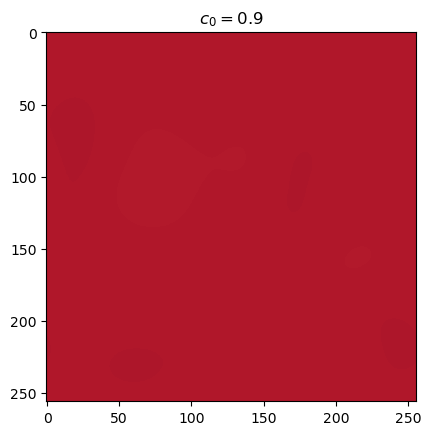

In [8]:
c_hat[:] = fft2(c[0]) #Fourier coefficients

for i in range(1,Nsteps):
    dfdc_hat[:] = fft2(dfdc(c[i-1])) # the FT of the derivative
    dfdc_hat *= dealias # dealising
    c_hat[:] = (c_hat-dt*K2*M*dfdc_hat)/(1+dt*M*kappa*K2**2) # updating in time
    c[i] = ifft2(c_hat).real # inverse fourier transform
    
print('c = ',c[-1].sum()*dx**2/L**2)

print('relative_error = ',np.abs(c[-1].sum()-c[0].sum())/c[0].sum())

plt.imshow(c[-1],cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.title('$c_0=%.1f$'% c0)
plt.savefig('cahn-hilliard-c0-%.1f.png'% c0)
plt.show()


In [9]:
# Print final average concentration and relative error
print('c = ', c[-1].sum() * dx ** 2 / L ** 2)
print('relative_error = ', np.abs(c[-1].sum() - c[0].sum()) / c[0].sum())

c =  0.9004963636398315
relative_error =  6.619087e-08


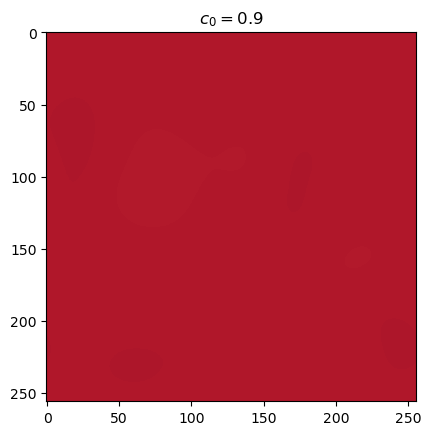

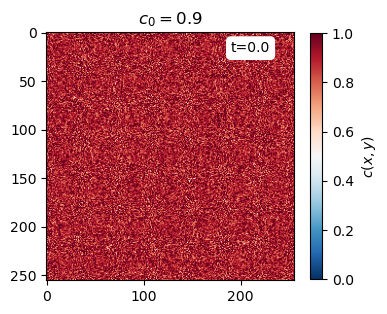

In [10]:

# Visualization of the final concentration
plt.imshow(c[-1], cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.title('$c_0=%.1f$' % c0)
plt.savefig('cahn-hilliard-c0-%.1f.png' % c0)
plt.show()

# Create and save animation
from matplotlib import animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(c[0], cmap='RdBu_r', vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r'$c(x,y)$', shrink=0.8)
tx = ax.text(190, 20, 't={:.1f}'.format(0.0),
             bbox=dict(boxstyle="round", ec='white', fc='white'))
ax.set_title(r'$c_0=%.1f$' % c0)


def animate(i):
    im.set_data(c[5 * i])
    im.set_clim(0.0, 1.0)
    tx.set_text('t={:.1f}'.format(5 * i * dt))
    return fig,


ani = animation.FuncAnimation(fig, animate, frames=199,
                              interval=50)
ani.save('ch-c0=' + str(c0) + '.gif', writer='pillow', fps=24, dpi=100)
